In [1]:
import pandas as pd 
%matplotlib inline
import matplotlib.pyplot as plt  # plotting library
import numpy as np  # numerical library
import datetime
import math
import matplotlib.dates as mdates # for timestamps

pd.options.display.max_rows = 14

In [2]:
df = pd.read_csv("../../data/data_Zhadang_localtime.csv", index_col=0, parse_dates=True)
df

,PRESSURE,ANGLE,WINDSPEED,NETRAD,RH,SWIN,SR50,TEMP,SWOUT,WINDDIR,SURFTEMP,PRCP
index,,,,,,,,,,,,
2010-10-02 00:00:00,507.133,2.209,1.500,-71.883,50.121,0.000,0.917,-2.887,0.000,191.563,-10.692,0.000000
2010-10-02 01:00:00,506.900,2.231,3.109,-85.910,45.190,0.000,0.916,-3.223,0.000,185.475,-11.491,0.000000
2010-10-02 02:00:00,506.483,2.203,3.217,-78.633,59.712,0.000,0.916,-3.912,0.000,149.389,-12.574,0.000000
2010-10-02 03:00:00,506.283,2.202,2.839,-74.421,64.127,0.000,0.916,-4.137,0.000,137.418,-13.135,0.000000
2010-10-02 04:00:00,506.000,2.234,3.335,-76.625,67.680,0.000,0.916,-4.241,0.000,135.399,-12.893,0.000000
2010-10-02 05:00:00,506.167,2.226,3.775,-76.633,64.840,0.000,0.918,-4.019,0.000,138.267,-12.780,0.000000
2010-10-02 06:00:00,506.450,2.177,3.512,-83.011,70.304,1.690,0.917,-4.500,1.690,140.116,-12.632,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2012-08-31 17:00:00,507.183,4.228,5.783,-1.609,93.368,72.083,-2.410,-1.040,63.353,317.309,-0.013,0.562083


In [3]:
# define constants

k = 0.4
z0m = 0.0017  # m
zm = 2  # m
zh = 2  # m
z0h = 0.0012  # m
cp = 1005  # J kg^-1 K^-1
rho = 1.29  # kg m^-3
P0 = 1010 # hPa

# 2. Turbulent fluxes
## 2.1 Sensible Heat Flux

Use the standard values from the appendix and the observations of Ts, Ta, and p at Zhadang to compute the sensible heat flux  QH. Plot it. When is it the most variable and why?

,PRESSURE,ANGLE,WINDSPEED,NETRAD,RH,SWIN,SR50,TEMP,SWOUT,WINDDIR,SURFTEMP,PRCP,Qh,month
index,,,,,,,,,,,,,,
2010-10-01,505.236706,2.259165,2.711933,0.466006,59.695001,220.251779,0.916055,-5.056112,172.646979,195.205835,-9.451981,0.029482,24.103480,10
2010-11-01,503.691769,2.333478,3.301117,-18.752425,47.180243,179.612736,NaN,-10.327746,147.985396,236.569436,-16.520272,0.015081,29.283566,11
2010-12-01,498.878159,2.357121,3.238926,-22.870843,36.808961,167.755305,NaN,-14.146203,126.165543,225.626848,-20.398035,0.001187,29.299738,12
2011-01-01,495.035980,2.453153,4.862489,-23.063028,44.497527,154.054360,NaN,-16.432429,121.206073,260.626878,-20.952890,0.005915,29.880604,1
2011-02-01,498.330836,2.420588,3.205302,-9.114470,37.193789,205.883987,NaN,-14.353031,163.290442,229.528683,-18.708751,0.002303,18.092507,2
2011-03-01,499.733702,2.475112,4.256914,-1.339108,44.778179,216.187897,NaN,-11.775210,163.268098,257.435664,-14.900629,0.014824,17.210420,3
2011-04-01,502.582982,2.439594,2.869425,5.598185,55.908636,295.820843,NaN,-7.753550,247.582322,213.703824,-10.328411,0.018846,11.327809,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-02-01,496.264448,1.429575,5.159264,-10.204963,39.754230,177.098892,0.336760,-13.599000,122.396726,261.291576,-15.908619,NaN,17.200840,2


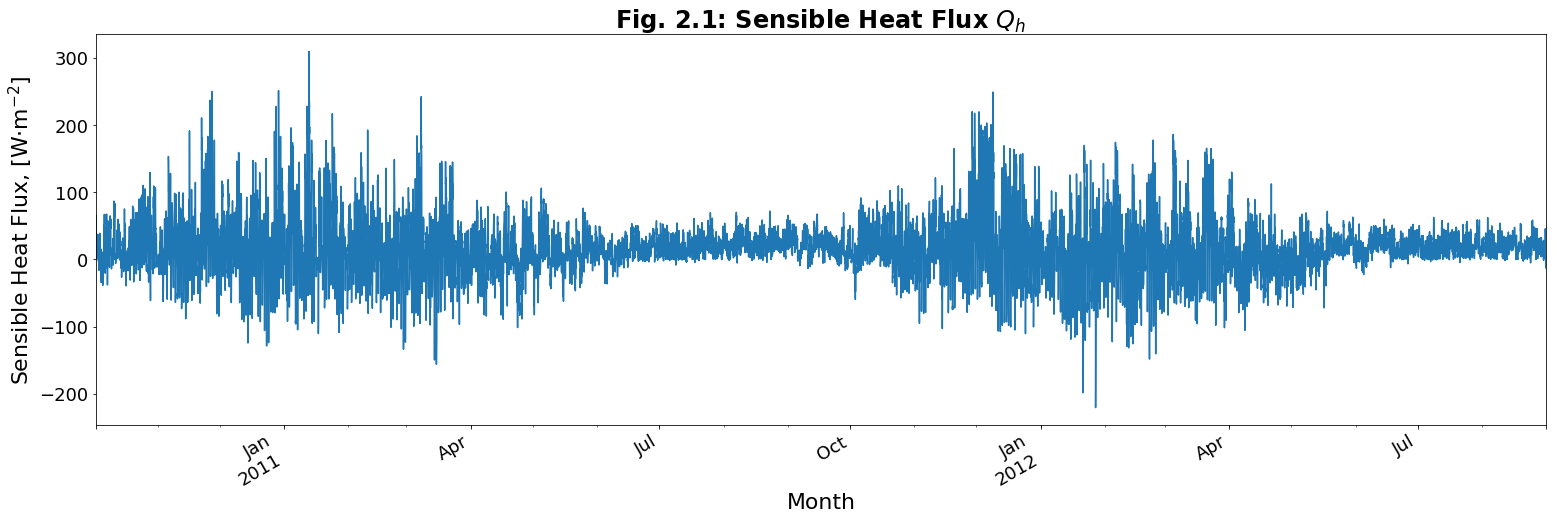

In [74]:
# Sensible heat flux
#df_jan = df.loc["01"]

Qh = (cp*rho*df["PRESSURE"]*(k**2)*df["WINDSPEED"]*(df["TEMP"]-df["SURFTEMP"]))/(P0 * np.log(zm/z0m) * np.log(zh/z0h))
df["Qh"] = Qh
Qh_std = Qh.std()
plt.figure(figsize=(26,8))
Qh.plot()
plt.title(r'Fig. 2.1: Sensible Heat Flux $Q_{h}$',
          fontweight='bold', fontsize=24)
plt.xlabel('Month', fontsize=22)
plt.ylabel('Sensible Heat Flux, [W$\cdot$m$^{-2}$]', fontsize=22)
# Change size of both axis descriptions
plt.tick_params(axis='both', labelsize=18)
plt.gcf().autofmt_xdate()

monthly_mean = df.resample('MS').mean()
monthly_mean

Plot the daily cycle of Q H in the months of January and July. When is QH negative/positive, and why?

index  index
1      1        12.587451
2      1         4.128623
3      1        18.097649
4      1        26.838959
5      1        31.921564
6      1        26.194157
7      1        26.043217
                  ...    
25     1        36.679923
26     1        27.193170
27     1        -5.315809
28     1        18.168412
29     1        21.695529
30     1         8.199588
31     1         7.553152
Name: Qh, Length: 31, dtype: float64

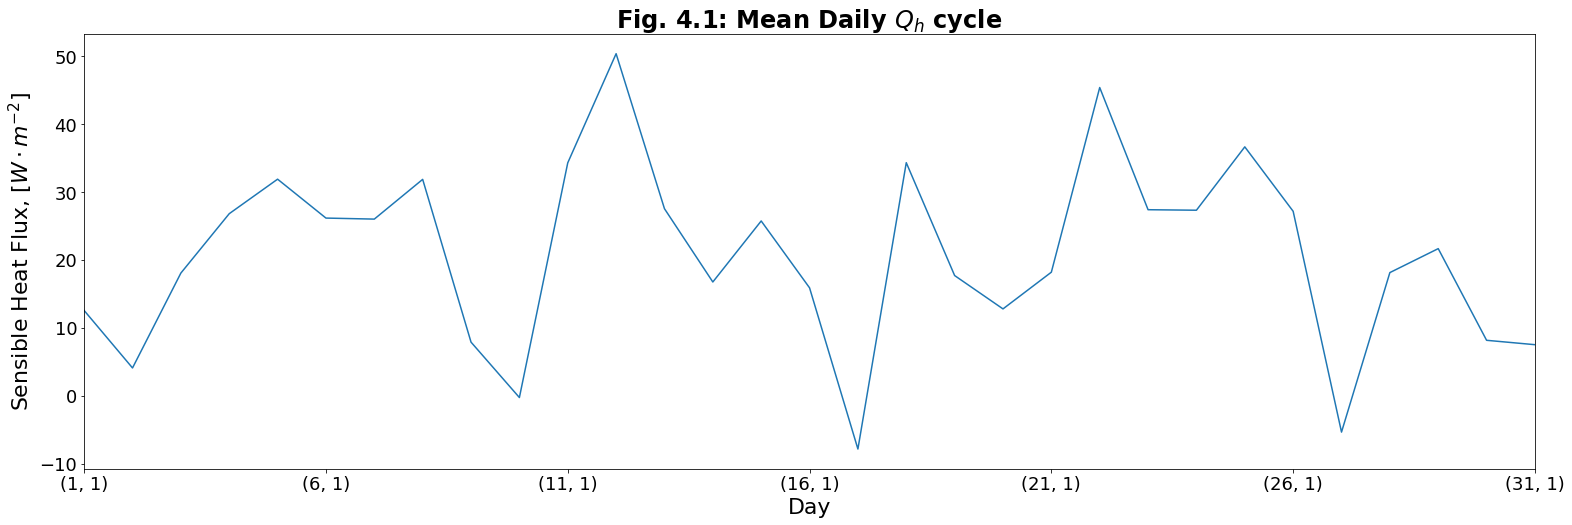

In [89]:
Qh_jan = df["Qh"].loc[df.index.month == 1]
Qh_jul = df["Qh"].loc[df.index.month == 7]

df_month_mean=df.groupby([df.index.day,df.index.month]).mean()
Qh_jan_mean = df_month_mean["Qh"].loc[df_month_mean["month"] == 1]

plt.figure(figsize=(26,8))
Qh_jan_mean.plot()
plt.title(r'Fig. 4.1: Mean Daily $Q_{h}$ cycle',
          fontweight='bold', fontsize=24)
plt.xlabel('Day', fontsize=22)
plt.ylabel("Sensible Heat Flux, [$W\cdot m^{-2}$]",fontsize=22)
# Change size of both axis descriptions
plt.tick_params(axis='both', labelsize=18)
x_ticks = mdates.DateFormatter("%d")
ax1.xaxis.set_major_formatter(x_ticks)
plt.xlabel("Day")
Qh_jan_mean

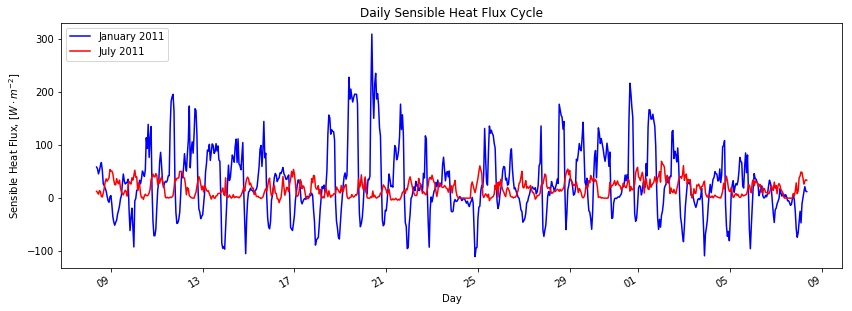

In [7]:
# Create plots and merge
fig, ax1 = plt.subplots(figsize=(14,5))
ax2 = ax1

# Select data to plot
hours = [datetime.datetime.now() + datetime.timedelta(hours=i) for i in range(len(df.loc["2011-01"]))]
qh_jan_11, = ax1.plot(hours, df.loc["2011-01"]["Qh"], label="January 2011", color='b')
qh_jul_11, = ax2.plot(hours, df.loc["2011-07"]["Qh"], label="July 2011", color='r')

# Create legend
cycles = [qh_jan_11, qh_jul_11]
ax1.legend(cycles, [cycle.get_label() for cycle in cycles], loc="upper left")

# Global figure properties
x_ticks = mdates.DateFormatter("%d")
ax1.xaxis.set_major_formatter(x_ticks)
plt.gcf().autofmt_xdate()
plt.xlabel("Day")
plt.ylabel("Sensible Heat Flux, [$W\cdot m^{-2}$]")
plt.title("Daily Sensible Heat Flux Cycle");
plt.show()

## 2.2 Latent Heat Flux

Use the formulas given in the appendix to compute the water vapor pressure of air and the saturation vapor pressure at the surface from the observations at Zhadang.

In [ ]:
# Saturation vapour pressure of air
esa = 6.11 * math.e ** (L*((1/T0)-(1/Ta))/Rv)
# Water vapour pressure of air
e_a = RH*e_sa/100

Compute the latent heat flux QL using the standard values from the appendix. Plot it. When is it the most variable and why?

Plot the daily cycle of QL for the months of January and July. When is QL negative/positive, and why

# 2.3 Flux Comparison
Plot the monthly averages of QH and QL for the entire measurement period.

Compare them with the net radiation energy flux. When will the turbulent fluxes play an important role, and when are they less relevant to the surface
energy balance?

# 2.4 Sensitivity to the meteorological conditions.

Compute the turbulent fluxes with changed meteorological conditions: ± 1K for air temperature, ±10% for wind speed. Display the results of the sensitivity experiments on the same plot.

Analyse the results. Why is QL also dependent on air temperature changes? Do such sensitivity experiments actually make sense, physically?

# 2.5 Sensitivity to the measurement heights.

Assess the importance of this varying snow cover conditions on sensor height by changing the measurement heights by ± 1 m. Discuss the importance of these parameters.

# 2.6 Sensitivity to the roughness parameters.
List some factors that can affect the roughness lengths. Find information on the order of magnitude by which these
roughness lengths can vary over a glacier surface.

Propose a sensitivity experiment for changing the roughness parameters altogether and plot the results.

Discuss the importance of these parameters, and the uncertainty associated with setting them as constant.

# 4. Mass Balance
## 4.1
Compute the melt.

## 4.2 
Compute the mass flux by deposition/sublimation as an analogy to the melt.

## 4.3 
Define a simple solution to estimate the snowfall amounts out of the PRCP variable

## 4.4
Compute the mass balance over the whole period of interest (kg m −2 ). Plot it as a time-
series, and as a cumulative mass change.

Compute and discuss the relative importance of each mass balance component to the total mass-balance.